In [32]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from datetime import datetime
tf.test.is_gpu_available()

True

In [33]:
# unpickle

pickle_file = 'SVHN_multi.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (212178, 32, 32, 1) (212178, 6)
Validation set (23576, 32, 32, 1) (23576, 6)
Test set (13068, 32, 32, 1) (13068, 6)


In [34]:
# helper methods for creating CNN
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d_same(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def conv2d_valid(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [35]:
# define parameters for model

image_size = 32
batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
num_labels = 11 # single digits and a blank
num_label_length = 6 # length 0 up to 5 digits
num_channels = 1 # gray
shape=[batch_size, image_size, image_size, num_channels]

graph = tf.Graph()

with graph.as_default():

    # Input parameters
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Weight and bias variables
    W_C1 = weight_variable([patch_size, patch_size, num_channels, depth1])
    b_C1 = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
    
    W_C2 = weight_variable([patch_size, patch_size, depth1, depth2])
    b_C2 = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
    
    W_C3 = weight_variable([patch_size, patch_size, depth2, num_hidden1])
    b_C3 = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')
    
    W_H = weight_variable([num_hidden1, num_labels])
    b_H = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='H')
    
    W_S1 = weight_variable([num_hidden1, num_labels])
    b_S1 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S1')
    
    W_S2 = weight_variable([num_hidden1, num_labels])
    b_S2 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S2')
    
    W_S3 = weight_variable([num_hidden1, num_labels])
    b_S3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S3')
    
    W_S4 = weight_variable([num_hidden1, num_labels])
    b_S4 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S4')
    
    W_S5 = weight_variable([num_hidden1, num_labels])
    b_S5 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S5')
  
  # neural network model
    def model(data, keep_prob, shape):
        # C1: convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
        conv =conv2d_valid(data, W_C1)
        hconv = tf.nn.relu(conv + b_C1)
        
        #Local response normalization
        lrn = tf.nn.local_response_normalization(hconv)
        
        # S2: sub-sampling layer, batch_size x 14 x 14 x 16
        maxpool = max_pool_2x2(lrn)
        
        # C3: convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
        conv =conv2d_valid(maxpool, W_C2)
        hconv = tf.nn.relu(conv + b_C2)
        
        #Local response normalization
        lrn = tf.nn.local_response_normalization(hconv)
        
        # S4: sub-sampling layer, batch_size x 5 x 5 x 32
        maxpool = max_pool_2x2(lrn)
        
        # C5: convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
        conv =conv2d_valid(maxpool, W_C3)
        hconv = tf.nn.relu(conv + b_C3)
        
        # Dropout
        dropout = tf.nn.dropout(hconv, keep_prob)
        
        # Reshaping tensor for fully connected layers
        shape = dropout.get_shape().as_list()
        flattened = tf.reshape(dropout, [shape[0], shape[1] * shape[2] * shape[3]])
        
        # F6: fully-connected layer, weight size: 64 x 16
        #FC = tf.nn.relu(tf.matmul(flattened, W_C4) + b_C4)
        length = tf.matmul(flattened, W_H) + b_H
        digit1 = tf.matmul(flattened, W_S1) + b_S1
        digit2 = tf.matmul(flattened, W_S2) + b_S2
        digit3 = tf.matmul(flattened, W_S3) + b_S3
        digit4 = tf.matmul(flattened, W_S4) + b_S4
        digit5 = tf.matmul(flattened, W_S5) + b_S5
        
        # Return vector with trafos for softmax
        return [length, digit1, digit2, digit3, digit4, digit5]
    
    # Define model and loss function
    [length, digit1, digit2, digit3, digit4, digit5] = model(tf_train_dataset, 0.95, shape)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(length, tf_train_labels[:,0])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(digit1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(digit2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(digit3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(digit4, tf_train_labels[:,4])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(digit5, tf_train_labels[:,5]))
    
    # Define optimizaer and learning rate
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.1, global_step, 40000, 0.9)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[4]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[5])])
    valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[4]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[5])])
    test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[4]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[5])])
    #Save model
    saver = tf.train.Saver()
    

In [66]:
# starting session and run computation
num_steps = 212000
print('Training start time: ', str(datetime.now()))
with tf.Session(graph=graph,config=tf.ConfigProto(log_device_placement=True)) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('%d %.1f %.1f %.1f' % (step, l, accuracy(predictions, batch_labels[:,0:6]), accuracy(valid_prediction.eval(), valid_labels[:,0:6])))
            #print('Minibatch loss at step %d: %f' % (step, l))
            #print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,0:6]))
            #print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels[:,0:6]))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,0:6]))
    save_path = saver.save(session, "SVHN_multi_1.ckpt")
    print('Training end time: ', str(datetime.now()))
    print("Model saved in file: %s" % save_path)
    

Training start time:  2017-01-04 13:47:17.592178
Initialized
0 17.2 2.3 50.8
500 7.1 58.6 59.8
1000 4.5 73.2 74.7
1500 3.0 84.9 83.2
2000 2.9 86.2 86.2
2500 2.5 85.4 88.2
3000 1.9 90.6 89.3
3500 2.0 89.6 90.2
4000 1.9 90.4 90.5
4500 2.4 90.1 90.4
5000 1.9 90.9 91.0
5500 2.2 89.6 91.5
6000 1.6 93.2 91.6
6500 1.7 90.9 92.0
7000 2.1 91.7 92.2
7500 1.6 92.2 92.3
8000 2.4 89.1 92.2
8500 1.8 93.8 92.2
9000 1.8 93.2 92.8
9500 1.9 91.7 92.9
10000 1.7 93.0 93.0
10500 1.4 93.2 93.1
11000 2.4 91.9 93.3
11500 1.2 94.5 93.4
12000 1.3 94.3 93.5
12500 1.9 93.8 93.5
13000 1.3 94.0 93.4
13500 1.1 93.5 93.6
14000 1.1 95.1 93.8
14500 1.1 95.3 93.9
15000 1.0 95.6 93.8
15500 1.7 94.5 93.9
16000 1.1 95.3 93.9
16500 1.2 95.3 93.9
17000 1.5 93.8 94.0
17500 0.8 96.4 94.0
18000 1.1 96.1 94.1
18500 1.4 94.3 94.1
19000 1.0 94.3 94.1
19500 1.6 93.0 94.3
20000 1.2 94.0 94.3
20500 1.5 94.5 94.2
21000 1.2 94.0 94.2
21500 1.7 93.5 94.4
22000 1.5 93.5 94.4
22500 0.7 96.6 94.4
23000 0.9 95.6 94.5
23500 1.4 94.8 94.4
240

[407, 4343, 4777, 5925, 8011, 8724, 8953, 9878, 9940, 12925]


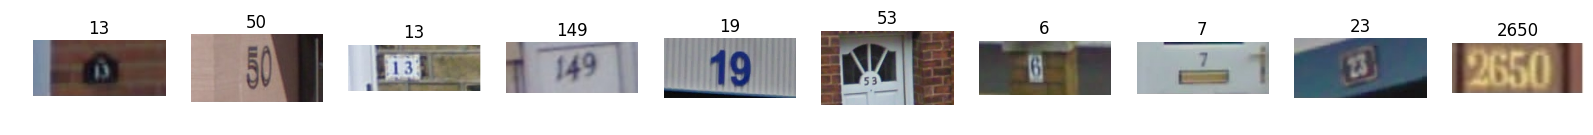

In [83]:
# printing a selection of pictures as a random sample and keep for later

from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

im_samples = []
    
for i, j in enumerate(np.sort(np.random.randint(0, test_labels.shape[0], size=10))):
    filename = str(j+1)+'.png'
    fullname = os.path.join('test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(test_labels[j,0]):
        house_num += str(test_labels[j,k+1])
    im_samples.extend([j])
    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)
    
print(im_samples)

In [84]:
# reloading the model

image_size = 32
batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
num_labels = 11 # single digits and a blank
num_label_length = 6 # length 0 up to 5 digits
num_channels = 1 # gray
shape=[batch_size, image_size, image_size, num_channels]

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_test_dataset = tf.placeholder(tf.float32, shape=(10, 32, 32, 1))

    # Variables.
    W_C1 = weight_variable([patch_size, patch_size, num_channels, depth1])
    b_C1 = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
    
    W_C2 = weight_variable([patch_size, patch_size, depth1, depth2])
    b_C2 = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
    
    W_C3 = weight_variable([patch_size, patch_size, depth2, num_hidden1])
    b_C3 = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')
    
    W_H = weight_variable([num_hidden1, num_labels])
    b_H = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='H')
    
    W_S1 = weight_variable([num_hidden1, num_labels])
    b_S1 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S1')
    
    W_S2 = weight_variable([num_hidden1, num_labels])
    b_S2 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S2')
    
    W_S3 = weight_variable([num_hidden1, num_labels])
    b_S3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S3')
    
    W_S4 = weight_variable([num_hidden1, num_labels])
    b_S4 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S4')
    
    W_S5 = weight_variable([num_hidden1, num_labels])
    b_S5 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S5')
  
  # reloading the model
    def model(data, keep_prob, shape):
        # C1: convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
        conv =conv2d_valid(data, W_C1)
        hconv = tf.nn.relu(conv + b_C1)
        
        #Local response normalization
        lrn = tf.nn.local_response_normalization(hconv)
        
        # S2: sub-sampling layer, batch_size x 14 x 14 x 16
        maxpool = max_pool_2x2(lrn)
        
        # C3: convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
        conv =conv2d_valid(maxpool, W_C2)
        hconv = tf.nn.relu(conv + b_C2)
        
        #Local response normalization
        lrn = tf.nn.local_response_normalization(hconv)
        
        # S4: sub-sampling layer, batch_size x 5 x 5 x 32
        maxpool = max_pool_2x2(lrn)
        
        # C5: convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
        conv =conv2d_valid(maxpool, W_C3)
        hconv = tf.nn.relu(conv + b_C3)
        
        # Dropout
        dropout = tf.nn.dropout(hconv, keep_prob)
        
        # Reshaping tensor for fully connected layers
        shape = dropout.get_shape().as_list()
        flattened = tf.reshape(dropout, [shape[0], shape[1] * shape[2] * shape[3]])
        
        # F6: fully-connected layer, weight size: 64 x 16
        #FC = tf.nn.relu(tf.matmul(flattened, W_C4) + b_C4)
        length = tf.matmul(flattened, W_H) + b_H
        digit1 = tf.matmul(flattened, W_S1) + b_S1
        digit2 = tf.matmul(flattened, W_S2) + b_S2
        digit3 = tf.matmul(flattened, W_S3) + b_S3
        digit4 = tf.matmul(flattened, W_S4) + b_S4
        digit5 = tf.matmul(flattened, W_S5) + b_S5
        
        # Return vector with trafos for softmax
        return [length, digit1, digit2, digit3, digit4, digit5]
    
    
    # call model function
    [length, digit1, digit2, digit3, digit4, digit5] = model(tf_test_dataset, 1, [10, 32, 32, 1])

    predict = tf.pack([tf.nn.softmax(length),tf.nn.softmax(digit1),tf.nn.softmax(digit2),tf.nn.softmax(digit3),tf.nn.softmax(digit4),tf.nn.softmax(digit5)])
    test_prediction = tf.transpose(tf.argmax(predict, 2))
    saver = tf.train.Saver()
#carry out prediction with the random sample from above
with tf.Session(graph=graph) as session:
    saver.restore(session, "SVHN_multi_1.ckpt")
    print("Model restored.")  

    print('Initialized')
    test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset[im_samples,:,:,:],})
    print(test_prediction)

Model restored.
Initialized
[[ 2  1  1 10 10 10]
 [ 2  5  0 10 10 10]
 [ 2  1  3 10 10 10]
 [ 3  1  4  9 10 10]
 [ 2  1  9  1 10 10]
 [ 2  5  3 10 10 10]
 [ 1  6 10 10 10 10]
 [ 1  7 10 10 10 10]
 [ 1  2  3 10 10 10]
 [ 4  2  6  5  0 10]]


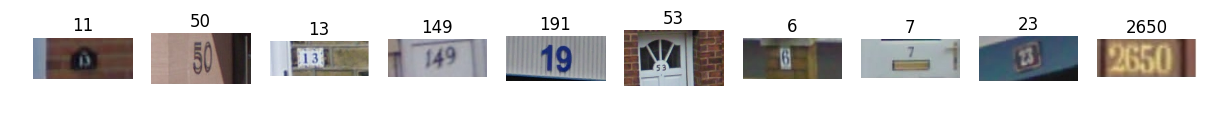

In [85]:
# plot predictions of the random sample

plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(im_samples):
    filename = str(j+1)+'.png'
    fullname = os.path.join('test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(np.sum(test_prediction[i,:] != 10)-1):
        house_num += str(test_prediction[i,k+1])

    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)